In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.weightstats import ztest as ztest

In [4]:
df_sample = pd.read_csv('data_samples/patient_0_train.psv', sep='|')
all_columns = list(df_sample.columns)
df_sample.head(10)

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,75.91,0,0,1,-98.6,1,0
1,61.0,99.0,36.44,124.0,65.0,43.0,17.5,NaN,NaN,NaN,...,NaN,NaN,NaN,75.91,0,0,1,-98.6,2,0
2,64.0,98.0,NaN,125.0,64.0,41.0,27.0,NaN,NaN,NaN,...,NaN,NaN,NaN,75.91,0,0,1,-98.6,3,0
3,56.0,100.0,NaN,123.0,65.0,41.0,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,75.91,0,0,1,-98.6,4,0
4,66.0,99.0,NaN,120.0,67.0,43.0,23.0,NaN,NaN,NaN,...,NaN,NaN,NaN,75.91,0,0,1,-98.6,5,0
5,94.0,100.0,36.22,194.0,116.0,66.0,14.0,NaN,NaN,NaN,...,NaN,NaN,NaN,75.91,0,0,1,-98.6,6,0
6,58.0,99.0,NaN,133.0,68.0,43.0,13.0,NaN,NaN,NaN,...,NaN,NaN,NaN,75.91,0,0,1,-98.6,7,0
7,57.0,100.0,NaN,118.0,62.0,37.0,18.0,NaN,NaN,NaN,...,NaN,NaN,NaN,75.91,0,0,1,-98.6,8,0
8,62.0,100.0,NaN,126.0,66.0,37.0,12.0,NaN,NaN,NaN,...,NaN,NaN,NaN,75.91,0,0,1,-98.6,9,0
9,58.0,95.0,36.11,143.0,77.0,47.0,11.0,NaN,NaN,22.0,...,11.0,NaN,158.0,75.91,0,0,1,-98.6,10,0


## Features exploration

Our data contains tables representing 20,000 patients.  
Each table contains clinical data about a single patient that was collected hourly during his stay in the hospital. In addition, the table also contains columns with data that doesn't change over time - specifically age, gender, unit1, unit2 and HospAdmTime. ICULOS Is a counter column that represents the hour since ICU admit until that moment. The other 35 columns contains the clinical measurements of the patient and thus may change hourly.  
Out of the 41 columns, 4 features are binary-categorical (gender, unit1, unit2, SepsisLabel) while the other features are continuous.  

We will want to explore the features divided to 2 groups - had sepsis or didn't have sepsis, in order to compare the values in both classes. We look at all the values of a patient as "had sepsis" if the patient has at least one row where SepsisLabel=1. We will perform the data exploration on the training data only.


In [3]:
dfs = []
for file in os.listdir('../data/train/'):
    df = pd.read_csv(f"../data/train/{file}", sep='|')[['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime','ICULOS', 'SepsisLabel']]
    dfs.append(df.tail(1))
constant_data = pd.concat(dfs).reset_index(drop=True)

In [4]:
had_sepsis = constant_data['SepsisLabel'].sum()
print(f'The number of patients that had Sepsis: {had_sepsis}')
print(f'The percentage of patients that had Sepsis: {100 * had_sepsis / constant_data.shape[0]}%')

The number of patients that had Sepsis: 1415
The percentage of patients that had Sepsis: 7.075%


As we can notice, the training data is not balanced - the class of patients that had sepsis is 7% of the data, leading to the other class to contain almost 93% of the data. As we look deeper into the distributions of the features values, we will consider their density (normalized values) instead of counters to make them comparable.  

### Demographics
We'll start by looking at the constant features - age, gender, unit1, unit2 and HospAdmTime, as well as ICULOS - the ICU length of stay, for which only the final value matters in this case.

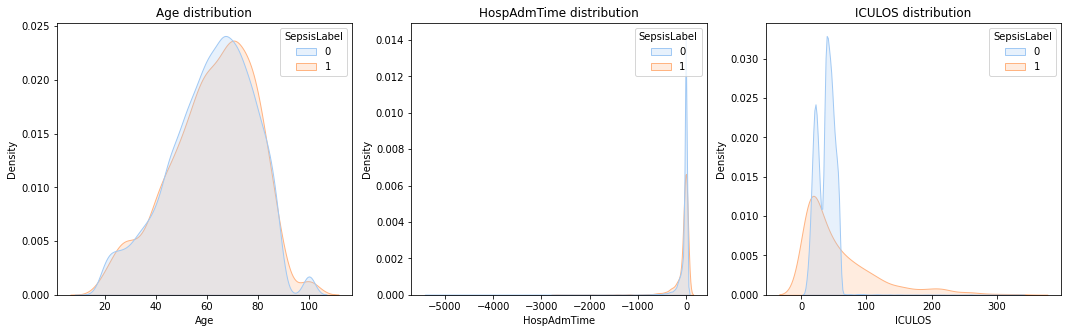

In [4]:
colors=sns.color_palette('pastel')[:2]
fig, axes = plt.subplots(1,3, figsize=(18,5))
for ax, col in zip(axes, ['Age', 'HospAdmTime', 'ICULOS']):
    sns.kdeplot(data = constant_data, x=col, hue = 'SepsisLabel', common_norm = False, fill=True, palette=colors, ax=ax)
    ax.set_title(f'{col} distribution')    
plt.show()


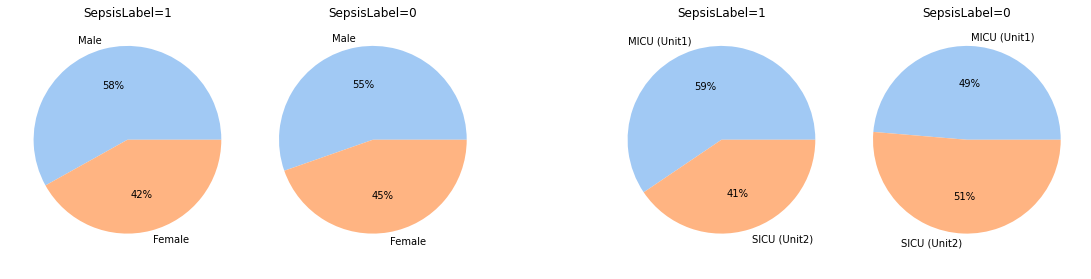

In [6]:
labels = {'Gender':['Male', 'Female'], 'Unit1':['MICU (Unit1)', 'SICU (Unit2)']}
colnames = {'Gender': 'Gender', 'Unit1':'Units'}
fig = plt.figure(constrained_layout=True)
fig.set_figwidth(15)
subfigs = fig.subfigures(nrows=1, ncols=2, wspace=0.2)
for subfig, col in zip(subfigs, ['Gender', 'Unit1']):
    subfig.suptitle(f'{colnames[col]} distribution', fontsize='x-large')
    axes = subfig.subplots(1,2)
    had_sepsis_0 = len(constant_data[(constant_data[col]==0) & (constant_data['SepsisLabel']==1)])
    had_sepsis_1 = len(constant_data[(constant_data[col]==1) & (constant_data['SepsisLabel']==1)])
    no_sepsis_0 = len(constant_data[(constant_data[col]==0) & (constant_data['SepsisLabel']==0)])
    no_sepsis_1 = len(constant_data[(constant_data[col]==1) & (constant_data['SepsisLabel']==0)])
    axes[0].pie(x=[had_sepsis_1, had_sepsis_0], labels=labels[col], autopct='%.0f%%', colors=colors)
    axes[0].set_title('SepsisLabel=1')
    axes[1].pie(x=[no_sepsis_1, no_sepsis_0], labels=labels[col], autopct='%.0f%%', colors=colors)
    axes[1].set_title('SepsisLabel=0')
plt.show()
    

As we can see in the graphs, the age, HospAdmTime and gender distributions are similar for patients with and without sepsis. For the HospAdmTime (hours between hospital admit and ICU admit) we can notice a long-tail distribution - most patients are admitted to an ICU only a few hours after admitting to the hospital, but there are a few patients that are hospitalized for a long time before being admitted to an ICU. The length of stay (ICULOS) is relatively longer for patients with sepsis. In the Intensive Care Units we see a slight difference between the classes - patients with sepsis are admitted more to the MICU (medical ICU) than to the SICU (Surgical ICU), in comparison to patients without sepsis. It is important to note that for some patients there is no value in the units columns, thus they are not counted in the graphs (we will elaborate more on that in the missing values section).

We will perform hypothesis testing using the z-test to compare the distributions of HospAdmTime and ICULOS in order to check if the difference between them is considered significant. The z-test is fitted to test if a difference exists between two distributions of large populations. In our case, the null hypothesis is that there is no difference between the distributions, and we will check whether we can reject it.

In [7]:
# HospAdmTime
HospAdmTime_test_stat, HospAdmTime_p_val = ztest(constant_data[constant_data['SepsisLabel'] == 0]['HospAdmTime'], constant_data[constant_data['SepsisLabel'] == 1]['HospAdmTime'], value=0)
print(f'HospAdmTime - the p-value of the test is {HospAdmTime_p_val:.3}')

# ICULOS
ICULOS_test_stat, ICULOS_p_val = ztest(constant_data[constant_data['SepsisLabel'] == 0]['ICULOS'], constant_data[constant_data['SepsisLabel'] == 1]['ICULOS'], value=0)
print(f'ICULOS - the p-value of the test is {ICULOS_p_val:.3}')

HospAdmTime - the p-value of the test is 3.78e-11
ICULOS - the p-value of the test is 2.39e-294


As we can see from the p-values of the tests, they are both < 0.05 and thus we have sufficient evidence to reject the null hypothesis, meaning that the distributions of the features is significantly different between both classes.

### Vital signs
The vital signs and laboratory values are measures that may change hourly per every patient. In order to analyze the data graphically for all patients, we would want to choose a single value from every feature to "represent" the patient and allow us to look at the distributions as we did before. We chose to look at the median value of those measure, as it is less sensitive to noise and may give us reliable results.

In [7]:
dfs = []
for file in os.listdir('../data/train/'):
    df = pd.read_csv(f"../data/train/{file}", sep='|')
    has_sepsis = df.tail(1)['SepsisLabel'].values[0]
    df_med = pd.DataFrame(df.median()).T
    df_med['SepsisLabel'] = has_sepsis
    dfs.append(df_med)
non_constant_data = pd.concat(dfs).reset_index(drop=True).drop(columns=['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS'])

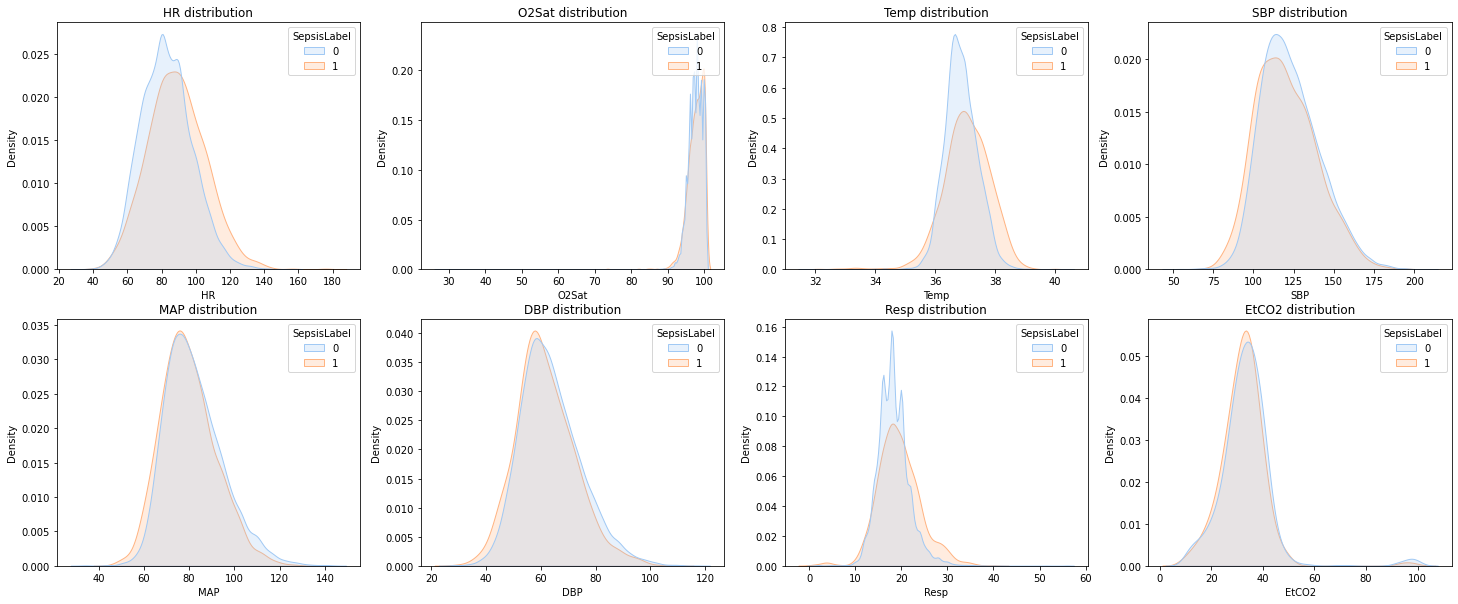

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(25,10))
vital_signs_columns = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
for ax, col in zip(axes.reshape(-1), vital_signs_columns):
    sns.kdeplot(data = non_constant_data, x=col, hue = 'SepsisLabel', common_norm = False, fill=True, palette=colors, ax=ax)
    ax.set_title(f'{col} distribution')    
plt.show()

Most vital signs show similar distributions between patients that had or didn't have sepsis. We can notice a small difference in the HR (heart rate), Temp and Resp (respiration rate) distributions, for which they are lower for patients without sepsis. We will again use the z-test to compare the distributions of the above features between the classes.

In [10]:
for col in vital_signs_columns:
    test_stat, p_val = ztest(non_constant_data[non_constant_data['SepsisLabel'] == 0][col].dropna(), non_constant_data[non_constant_data['SepsisLabel'] == 1][col].dropna(), value=0)
    print(f'{col} - the p-value of the test is {p_val:.3}')

HR - the p-value of the test is 7.82e-46
O2Sat - the p-value of the test is 0.0214
Temp - the p-value of the test is 2.53e-32
SBP - the p-value of the test is 1.34e-07
MAP - the p-value of the test is 2.43e-12
DBP - the p-value of the test is 1.38e-08
Resp - the p-value of the test is 2.97e-34
EtCO2 - the p-value of the test is 0.0811


The EtCO2 is the only sign for which the p-value > 0.05, thus it is the only feature within this group for which the distributions are similar. Surprisingly, for all the other features we can reject the null hypothesis, meaning the distributions are significantly different between both classes.

### Laboratory values

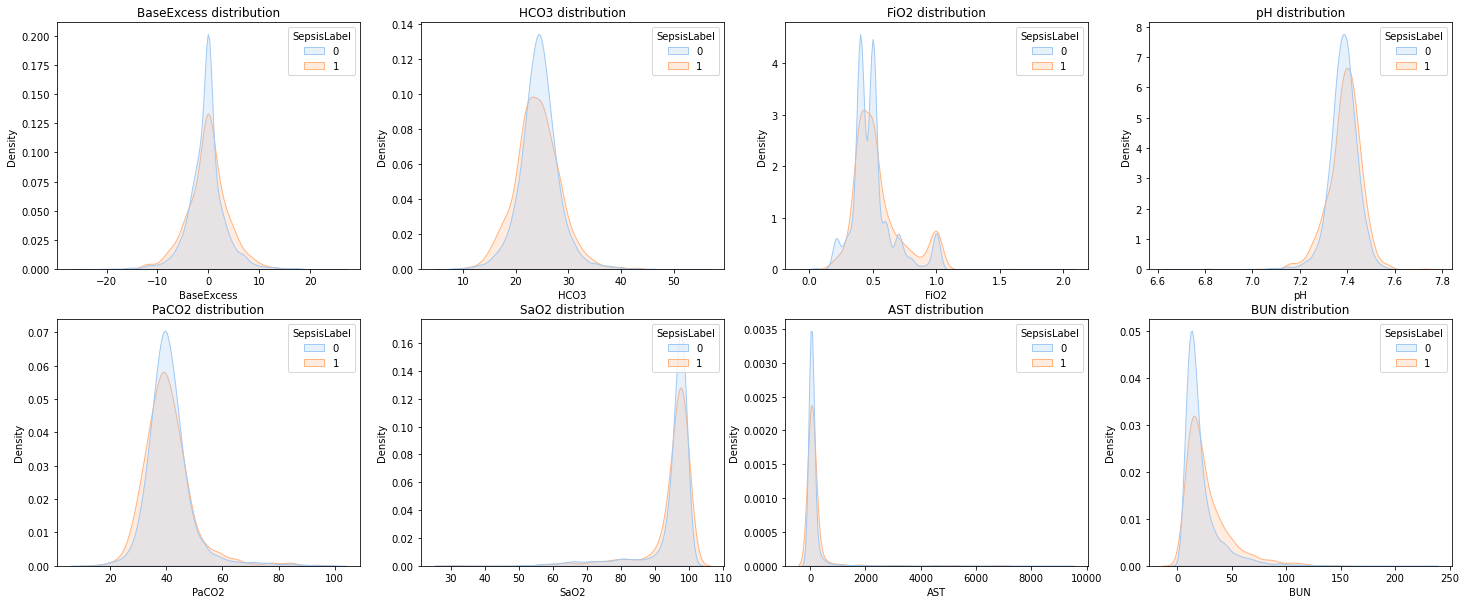

In [11]:
fig, axes = plt.subplots(2, 4, figsize=(25,10))
laboratory_values_a = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN']
for ax, col in zip(axes.reshape(-1), laboratory_values_a):
    sns.kdeplot(data = non_constant_data, x=col, hue = 'SepsisLabel', common_norm = False, fill=True, palette=colors, ax=ax)
    ax.set_title(f'{col} distribution')
plt.show()

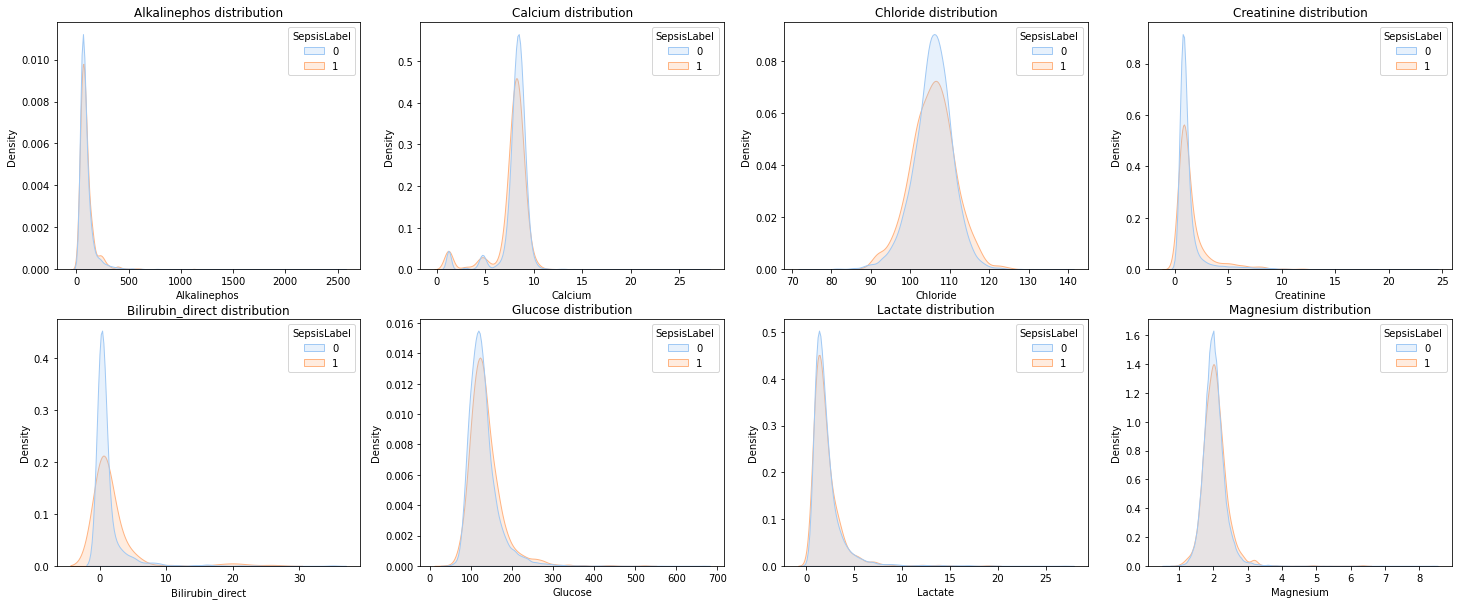

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(25,10))
laboratory_values_b = ['Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium']
for ax, col in zip(axes.reshape(-1), laboratory_values_b):
    sns.kdeplot(data = non_constant_data, x=col, hue = 'SepsisLabel', common_norm = False, fill=True, palette=colors, ax=ax)
    ax.set_title(f'{col} distribution')
plt.show()

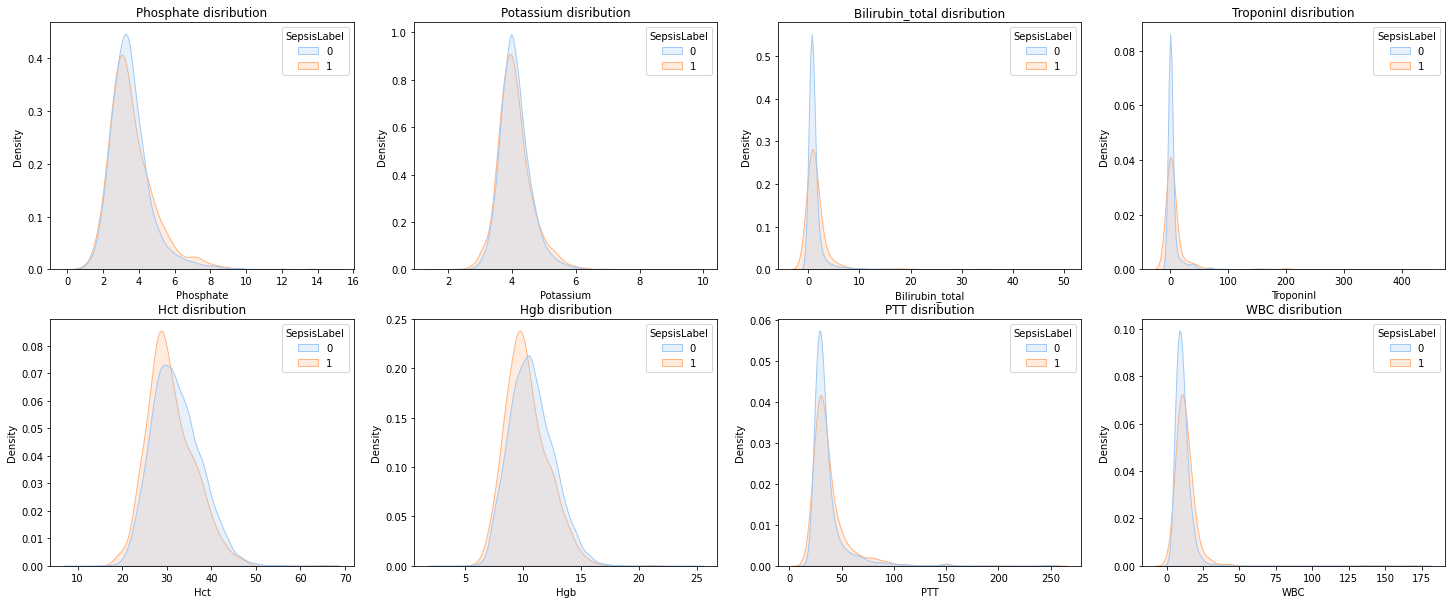

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(25,10))
laboratory_values_c = ['Phosphate', 'Potassium','Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC']
for ax, col in zip(axes.reshape(-1), laboratory_values_c):
    sns.kdeplot(data = non_constant_data, x=col, hue = 'SepsisLabel', common_norm = False, fill=True, palette=colors, ax=ax)
    ax.set_title(f'{col} disribution')
plt.show()

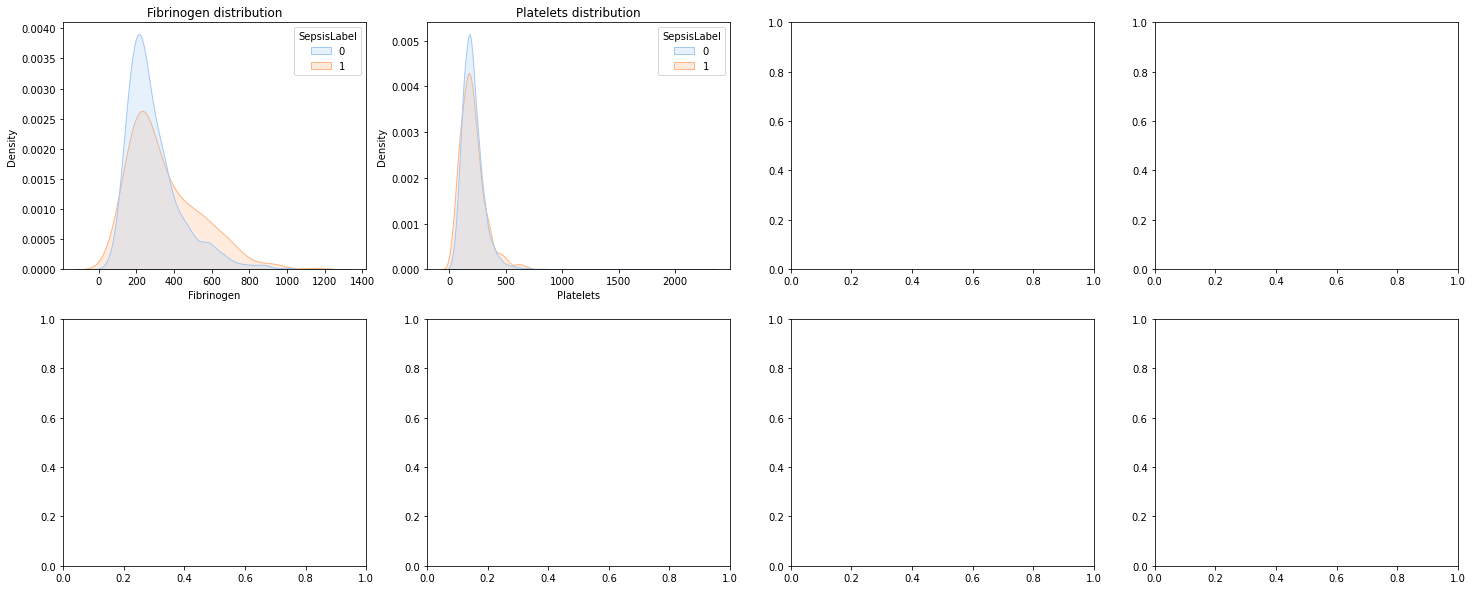

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(25,10))
laboratory_values_d = ['Fibrinogen', 'Platelets']
for ax, col in zip(axes.reshape(-1), laboratory_values_d):
    sns.kdeplot(data = non_constant_data, x=col, hue = 'SepsisLabel', common_norm = False, fill=True, palette=colors, ax=ax)
    ax.set_title(f'{col} distribution')
plt.show()

For the laboratory values, most measures have very similar distributions (visually) between patients with and without sepsis. We notice that in the majority of the features, the distribution for SepsisLabel=1 (colored in orange) seems to be wider, meaning there is higher variance in the values. This might be intuitive as we can expect that an abnormal medical condition would lead to different measures than when the condition doesn't exist, and specifically to more extreme measures. The Hct (Hematocrit), Hgb (Hemoglobin) and Fibrinogen do show slightly different distributions, where patients with sepsis tend to have relatively lower measures of Hct and Hgb and higher measures of Fibrinogen.
We will test all of the above features with the z-test to check for statistical differences within the distributions.

In [15]:
laboratory_values = [*laboratory_values_a, *laboratory_values_b, *laboratory_values_c, *laboratory_values_d]

for col in laboratory_values:
    test_stat, p_val = ztest(non_constant_data[non_constant_data['SepsisLabel'] == 0][col].dropna(), non_constant_data[non_constant_data['SepsisLabel'] == 1][col].dropna(), value=0)
    if p_val < 0.05:
        print(f'{col} - the p-value of the test is {p_val:.3}')

HCO3 - the p-value of the test is 0.0177
FiO2 - the p-value of the test is 7.38e-15
pH - the p-value of the test is 0.00351
BUN - the p-value of the test is 4.27e-31
Calcium - the p-value of the test is 4.03e-17
Creatinine - the p-value of the test is 2.52e-07
Bilirubin_direct - the p-value of the test is 0.00728
Glucose - the p-value of the test is 4.2e-10
Magnesium - the p-value of the test is 0.00106
Phosphate - the p-value of the test is 0.0162
Bilirubin_total - the p-value of the test is 4.06e-05
Hct - the p-value of the test is 4.58e-15
Hgb - the p-value of the test is 1.57e-15
PTT - the p-value of the test is 0.000184
WBC - the p-value of the test is 9.39e-31
Fibrinogen - the p-value of the test is 5.47e-08


Out of 26 laboratory values, we reject 16 of the tests and conclude that the distribution are significantly different between the classes. It is important to notice that the significance levels are different in each test, but in all of them it is < 0.05.

## Missing values

We will now want to check how much missing data we have. We will look at the combined data from all patients and compute the percentage of missing data for each feature. In addition, for each feature we check the percentage of patients that the whole column is missing for them.
Note that we look at the entire data, including rows that eventually might not be used for the prediction models, as we still want to get a big picture of how the data looks.

In [5]:
dfs = []
all_missing = {col:0 for col in all_columns}
for file in os.listdir('../data/train/'):
    df = pd.read_csv(f"../data/train/{file}", sep='|')
    for col in all_columns:
        if df[col].isnull().all():
            all_missing[col] += 1
    dfs.append(df)
all_data = pd.concat(dfs).reset_index(drop=True)

In [7]:
all_missing_pct = {col: 100 * num_missing/20000 for col,num_missing in all_missing.items()}

percent_missing = all_data.isnull().sum() * 100 / len(all_data)
missing_values_df = pd.DataFrame({'feature_name': all_data.columns, 'percent_missing': percent_missing, 'percent_patients_with_all_missing':list(all_missing_pct.values())}).sort_values(by='percent_patients_with_all_missing').reset_index(drop=True)

missing_values_df

,feature_name,percent_missing,percent_patients_with_all_missing
0,SepsisLabel,0.000000,0.000
1,HospAdmTime,0.000000,0.000
2,Gender,0.000000,0.000
3,Age,0.000000,0.000
4,ICULOS,0.000000,0.000
5,HR,9.906453,0.015
6,O2Sat,13.066122,0.060
7,Resp,15.431408,0.180
8,MAP,12.492893,0.220
9,Temp,66.077269,0.655


<AxesSubplot:xlabel='feature_name'>

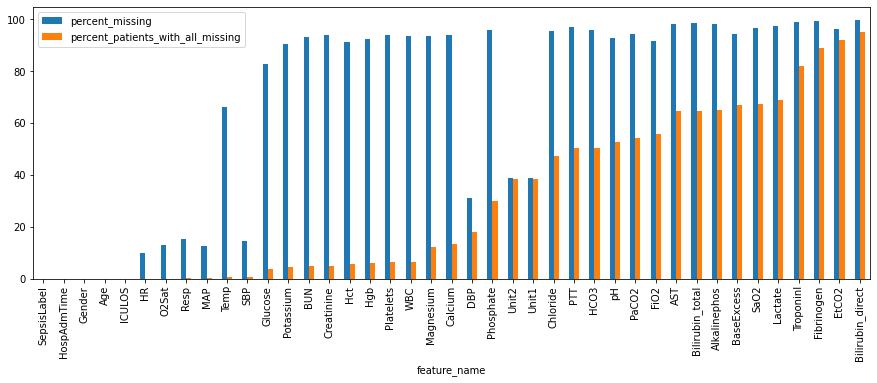

In [14]:
missing_values_df[["feature_name", "percent_missing", "percent_patients_with_all_missing"]].plot(x="feature_name", kind="bar", figsize=(15,5))

We can notice there are 4 features with a high percentage of missing values, leading to a high percentage of patients that the whole column of those features are missing for them. Those column are TroponinI, Fibrinogen, EtCO2, Bilirubin_direct, and since we don't have enough data to learn from them, they will be removed from our analysis from now on.

## Feature correlation

In [5]:
dfs_median = []
for file in os.listdir('../data/train/'):
    df = pd.read_csv(f"../data/train/{file}", sep='|')
    has_sepsis = df.tail(1)['SepsisLabel'].values[0]
    df_med = pd.DataFrame(df.median()).T
    df_med['SepsisLabel'] = has_sepsis
    dfs_median.append(df_med)
all_data_median = pd.concat(dfs_median).reset_index(drop=True)


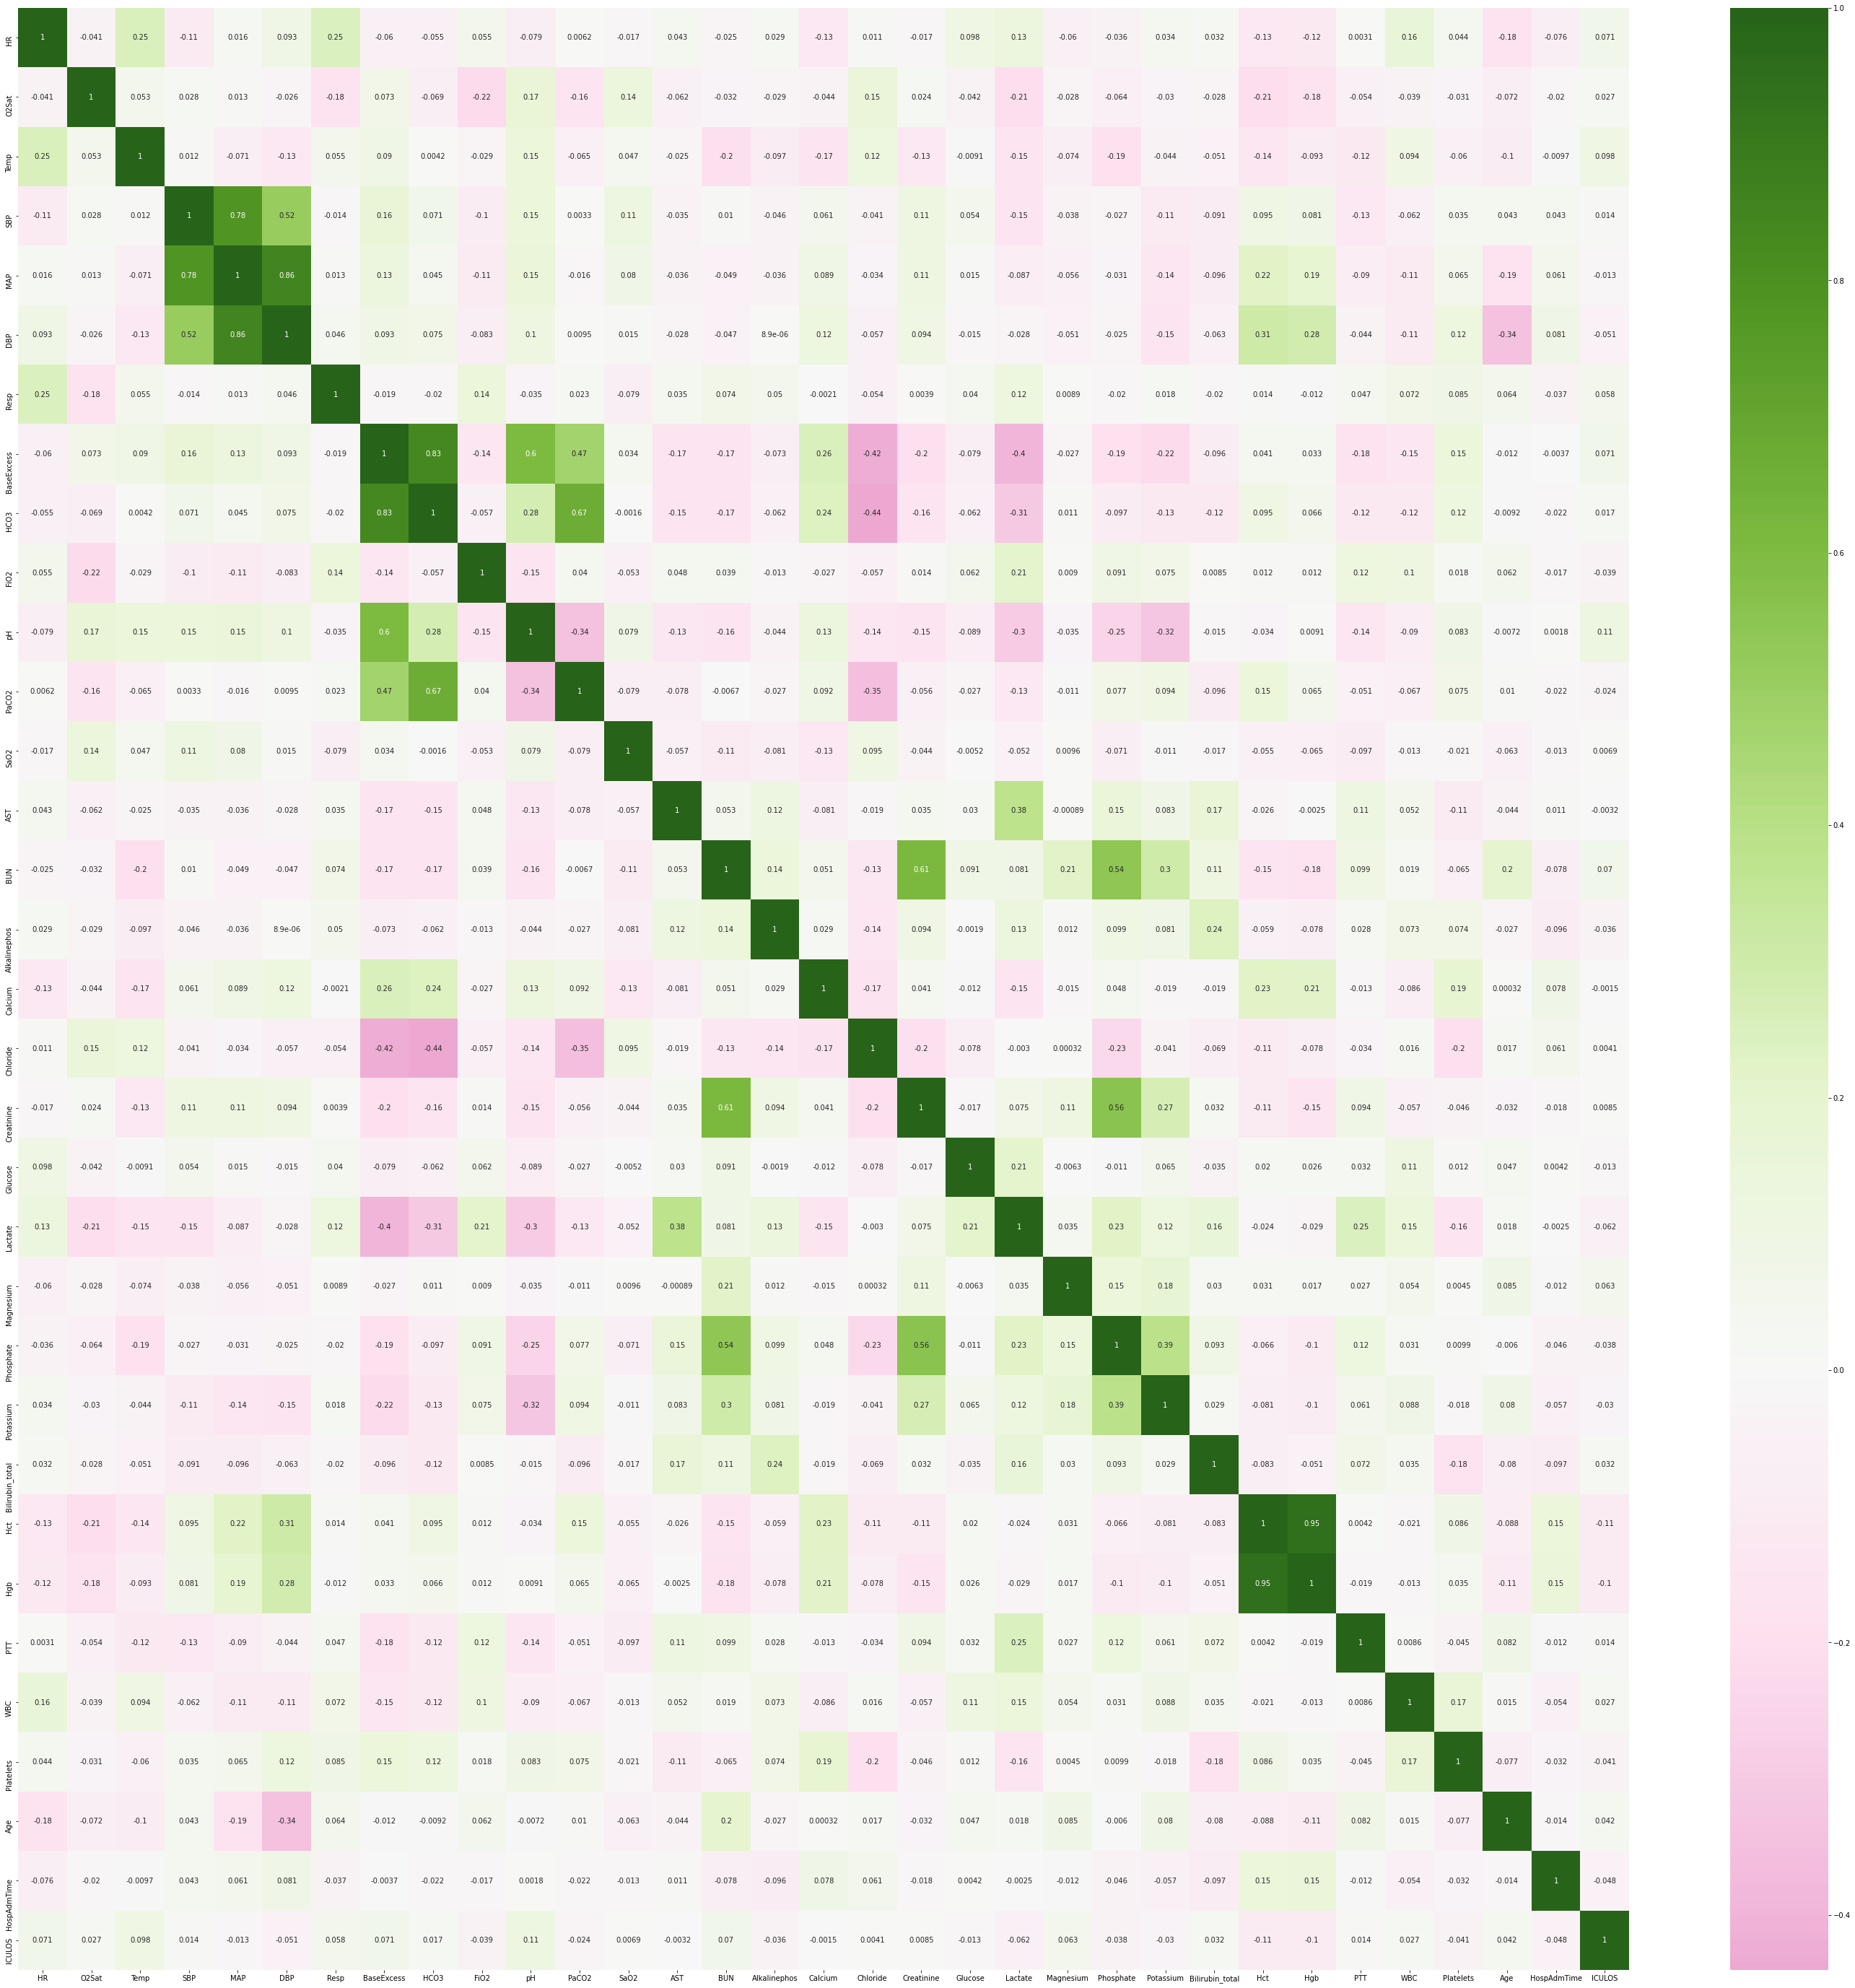

In [6]:
all_data_median = all_data_median.drop(columns=['SepsisLabel', 'Gender', 'Unit1', 'Unit2', 'TroponinI', 'Fibrinogen', 'EtCO2', 'Bilirubin_direct'])
all_data_corr = all_data_median.corr()

plt.figure(figsize=(50,50))
sns.heatmap(all_data_corr, annot=True, robust=False, cmap="PiYG", center = 0)
plt.show()

In [7]:
triangle_corr = (all_data_corr.where(np.triu(np.ones(all_data_corr.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))
correlation = pd.DataFrame(triangle_corr).reset_index().rename(columns={'level_0':'Feature 1', 'level_1':'Feature 2', 0:'Correlation'})
correlation

<ipython-input-7-95e4528b0dbd>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  triangle_corr = (all_data_corr.where(np.triu(np.ones(all_data_corr.shape), k=1).astype(np.bool))


,Feature 1,Feature 2,Correlation
0,Hct,Hgb,0.948520
1,MAP,DBP,0.857029
2,BaseExcess,HCO3,0.834159
3,SBP,MAP,0.783143
4,HCO3,PaCO2,0.666224
...,...,...,...
523,pH,PaCO2,-0.344540
524,PaCO2,Chloride,-0.351106
525,BaseExcess,Lactate,-0.397129
526,BaseExcess,Chloride,-0.423276
